<a href="https://colab.research.google.com/github/GeorgeWilliam1999/Q-computing/blob/main/Quantum_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##NEXT STEP
(to be updated every session)

Try other circuits

Finish binary classification using pandas formats

Workout how to use LIME on this classifier

In [1]:
!pip install qulacs
!pip install -q --upgrade ipython
!pip install -q --upgrade ipykernel

     |████████████████████████████████| 451 kB 4.2 MB/s 
     |████████████████████████████████| 791 kB 4.4 MB/s 
     |████████████████████████████████| 374 kB 51.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.24 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.30.1 which is incompatible.
     |████████████████████████████████| 126 kB 4.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.24 which is incompatible.
google-colab 1.0.0 requires ipykernel~=4.10, but you have ipykernel 6.6.0 which is incom

In [2]:
import qulacs
import numpy as np
from qulacs import QuantumState
from qulacs.gate import X, RY, RZ, DenseMatrix
from sklearn.datasets import load_iris
import seaborn as sns
import pandas as pd 

# QML
## Parameterised quantum circuit set up

The goal here is to recreate a circuit from Dominics thesis,

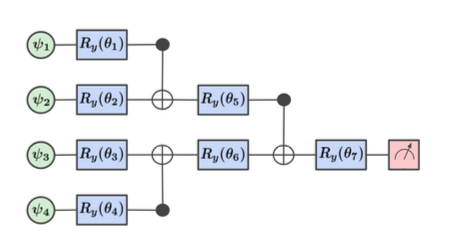

This circuit is able to perform binary classification of data. The anzats is convolutional which helps avoid the barren plat. which can prevent networks from being trained

## Iris data processing

In [3]:
#Load and view iris data set
iris = load_iris()
iris.DESCR

'.. _iris_dataset:\n\nIris plants dataset\n--------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 150 (50 in each of three classes)\n    :Number of Attributes: 4 numeric, predictive attributes and the class\n    :Attribute Information:\n        - sepal length in cm\n        - sepal width in cm\n        - petal length in cm\n        - petal width in cm\n        - class:\n                - Iris-Setosa\n                - Iris-Versicolour\n                - Iris-Virginica\n                \n    :Summary Statistics:\n\n    ============== ==== ==== ======= ===== ====================\n                    Min  Max   Mean    SD   Class Correlation\n    ============== ==== ==== ======= ===== ====================\n    sepal length:   4.3  7.9   5.84   0.83    0.7826\n    sepal width:    2.0  4.4   3.05   0.43   -0.4194\n    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)\n    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)\n    ============== ==== =

In [4]:
iris.data.shape,iris.target.shape

((150, 4), (150,))

In [5]:
#Load iris data and classification to the same array.
features = iris.feature_names
features.append('label')
data = np.zeros((150,5))
data[:,0:4] = iris.data
data[:,4] = iris.target

In [6]:
iris_df = pd.DataFrame(data = data, columns = features)

In [7]:
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.33, random_state=42)

train_data = np.zeros((X_train.shape[0], X_train.shape[1] + 1))
train_data[:,0:4] = X_train
train_data[:,4] = y_train
train_df = pd.DataFrame(data = train_data, columns = features)

test_data = np.zeros((X_test.shape[0], X_test.shape[1] + 1))
test_data[:,0:4] = X_test
test_data[:,4] = y_test
test_df = pd.DataFrame(data = test_data, columns = features)

Featurewise pair plots:

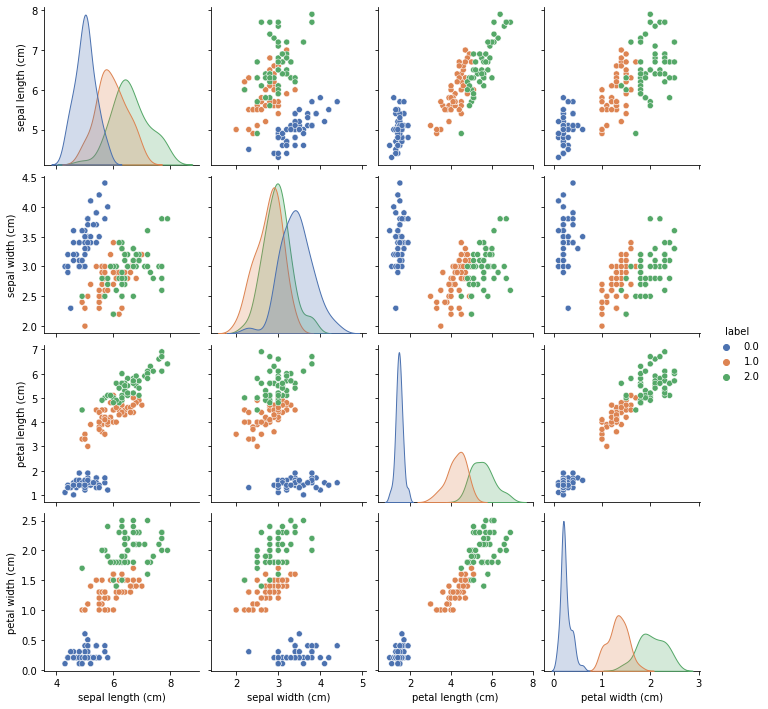

In [9]:
sns.pairplot(iris_df, hue="label", palette = 'deep')

## Data preprocessing and embedding

The data array has the form (x,y), where x is the feature vector and y is tge label. The feature vector has 4 element and the labels are 0,1,2 respectivly. To use a parameterised quantum circuit each data vector x must be transformed to a tensor product of qubits.

Encoding this data into qubits can be done in a number of ways. To begin with I will repeat the work done by Dominic, and use the qubit embedding $x_n^d \mapsto \bigotimes_{n=1}^4 cos(x_n^d) |0> + sin(x_n^d) |1>$ where $x_n^d$ is the nth feature of the dth sample. Note that this embedded state is the tensor product of 4 qubits, which gives a state vector of size $2^4 = 16$. Note also that for the qubit embedding we require all the x values be in the range $[0,\frac{\pi}{2})$.

To encode the data I will initialise 4 cubits in the $|0>$ computational basis state and operate on each them with the gate $U(X_n^d) := e^{-ix_n^d\sigma_y}$. This process will encode a single data points.

But first, the data will need normalising as described above.

Test train split

In [ ]:
#This function takes a data set and returns a qubit embedding of the data.
#Normalise from the bottom
def half_pi_norm(data):
  #Normalise data
  dim = data.shape[1]
  min_values = np.zeros(dim)
  for i in range(dim):
    min_values[i] = np.amin(data[:,i])
    data[:,i] = data[:,i] - min_values[i]
  print(min_values)


  largest_values = np.zeros(dim)
  for i in range(dim):
    largest_values[i] = np.amax(data[:,i])
  print(largest_values)

  #Normalise classical data
  normalised_data = np.zeros((data.shape[0],dim))

  for i in range(dim):

    normalised_data[:,i] = data[:,i]*(np.pi/(2*largest_values[i]))

  return normalised_data

Rescaled to be between 0 and pi/2 using pandas dataframe functions

In [ ]:
train_df[train_df.columns[:4]] -= train_df[train_df.columns[:4]].min()
train_df[train_df.columns[:4]] /= train_df[train_df.columns[:4]].max()
train_df[train_df.columns[:4]] *= np.pi/2

In [ ]:
train_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,0.646798,0.642598,0.869548,0.785398,1.0
1,1.524596,0.713998,1.542746,1.308997,2.0
2,0.600599,0.713998,0.953698,0.916298,1.0
3,0.369599,1.070997,0.084150,0.065450,0.0
4,1.570796,0.571199,1.570796,1.243547,2.0


In [ ]:
test_df[test_df.columns[:4]] -= test_df[test_df.columns[:4]].min()
test_df[test_df.columns[:4]] /= test_df[test_df.columns[:4]].max()
test_df[test_df.columns[:4]] *= np.pi/2

In [ ]:
test_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,0.762958,0.428399,0.985076,0.719948,1.0
1,0.583439,1.142397,0.186366,0.130900,0.0
2,1.481037,0.285599,1.570796,1.439897,2.0
3,0.718078,0.499799,0.931828,0.916298,1.0
4,1.077117,0.428399,1.011699,0.850848,1.0


In [ ]:
#normed_train_data = half_pi_norm(X_train)
#normed_test_data = half_pi_norm(X_test)

## Trinary Clasification

### Embedding circuit

Now I create the embedding circuit as a function that acts on a point and returns a quantum state.

In [ ]:
#Function to perform pointwise qubit embedding.
def pointwise_qubit_embedding(point):
  n = len(point)
  state = QuantumState(n)
  state.set_zero_state()
  for i in range(n):
    ry_gate = RY(i, point[i])
    ry_gate.update_quantum_state(state)

  return state

### Computational Circuit 

To build two qubit gates one needs to use combinations of single qubit gates and control operations.

I am copy the state after each operation for comparison.

Now its time for a parameterised quantum circuit.

Each two qubit unitary will be specified by two angles

In [ ]:
from qulacs import ParametricQuantumCircuit
from qulacs import QuantumState
import numpy as np
def U():
  #Metadata
  n = 4
  depth = 3
  angle = 0
  # construct parametric quantum circuit with random rotation
  circuit = ParametricQuantumCircuit(n)

  target_layer_1 = np.array([0,1,2,3], dtype = 'int')
  for i in target_layer_1:
    circuit.add_parametric_RY_gate(target_layer_1[i],angle)
  circuit.add_CNOT_gate(0,1)
  circuit.add_CNOT_gate(3,2)

  target_layer_2 = [1,2]
  for i in range(len(target_layer_2)):
    circuit.add_parametric_RZ_gate(target_layer_2[i],angle)
  circuit.add_CNOT_gate(1,2)

  circuit.add_parametric_RY_gate(2,angle)

  return circuit

In [ ]:
from qulacs import Observable

In [ ]:
circuit = U()
circuit.get_parameter_count()

7

In [ ]:
theta_0 = np.random.rand(7)
for i in range(circuit.get_parameter_count()):
  circuit.set_parameter(i,theta_0[i])

In [ ]:
circuit.get_parameter

<bound method PyCapsule.get_parameter of *** Quantum Circuit Info ***
# of qubit: 4
# of step : 5
# of gate : 10
# of 1 qubit gate: 7
# of 2 qubit gate: 3
Clifford  : no
Gaussian  : no

*** Parameter Info ***
# of parameter: 7
>

In [ ]:
parameter_count = circuit.get_parameter_count()
param = [circuit.get_parameter(ind) for ind in range(parameter_count)]

In [ ]:
param

[0.02337252187391836,
 0.46079065691883503,
 0.9903234774368801,
 0.0548763620086582,
 0.7623011477456286,
 0.43792462420740363,
 0.08492345430605619]

NOTE TO SELF

use pca on the components to see what the most important eigen vlaues/vectors are doing.

In [ ]:
train_df.iloc[0][0:3]

sepal length (cm)    0.646798
sepal width (cm)     0.642598
petal length (cm)    0.869548
Name: 0, dtype: float64

In [ ]:
#Update |0000...00> to embedded values using the first row of the training data.
state_1 = pointwise_qubit_embedding(train_df.iloc[0][0:3])
state_1.get_vector()

array([ 0.81594168+0.j, -0.27347609+0.j, -0.27157147+0.j,  0.09102158+0.j,
       -0.37893299+0.j,  0.12700554+0.j,  0.12612101+0.j, -0.0422715 +0.j])

In [ ]:
state_2 = state_1
circuit.update_quantum_state(state_2)
state_2.get_vector()

array([ 0.81594168+0.j, -0.27347609+0.j, -0.27157147+0.j,  0.09102158+0.j,
       -0.37893299+0.j,  0.12700554+0.j,  0.12612101+0.j, -0.0422715 +0.j])

### Define operators and make initial predictions

I will use the Pauli Z operator to take the expectation of the unitary evolution of embedded data points.

In [ ]:
from qulacs import PauliOperator
p_s = 'Z 1'
z = PauliOperator(p_s,1)

In [ ]:
pred = z.get_expectation_value(state_2)

In [ ]:
pred

(0.8005412409243602+0j)

In [ ]:
def get_expectation(x, U, theta):
  #define PQC
  circuit =  U()
  for i in range(circuit.get_parameter_count()):
    circuit.set_parameter(i,theta[i])

  #Define and embed data point, x is an element of the normalised data set
  point = x
  state = pointwise_qubit_embedding(point)
  circuit.update_quantum_state(state)
  obs = Observable(4)
  obs.add_operator(1.,'Z 1')
  exp = obs.get_expectation_value(state)

  '''if exp >= 0.33:
    pred = 2
  elif exp < 0.33 and exp > -0.33:
    pred = 1
  else:
    pred = 0'''

  return exp + 1

In [ ]:
#Classify and expectation value that is reshaped to be between 0 and 2.
def classi(exp):
  if exp >= 1.33:
    pred = 2
  elif exp < 1.33 and exp > 0.66:
    pred = 1
  else:
    pred = 0
  return pred

Below I visualise the naive predictions on the training data. Clearly the predictions are sub optimal.

In [ ]:
predictions = []
for i in range(len(train_df)):
  predictions.append(get_expectation(train_df.iloc[i][0:4],U,np.random.rand(7)))
train_df.insert(4,'Expectation', predictions)


Actual classes.

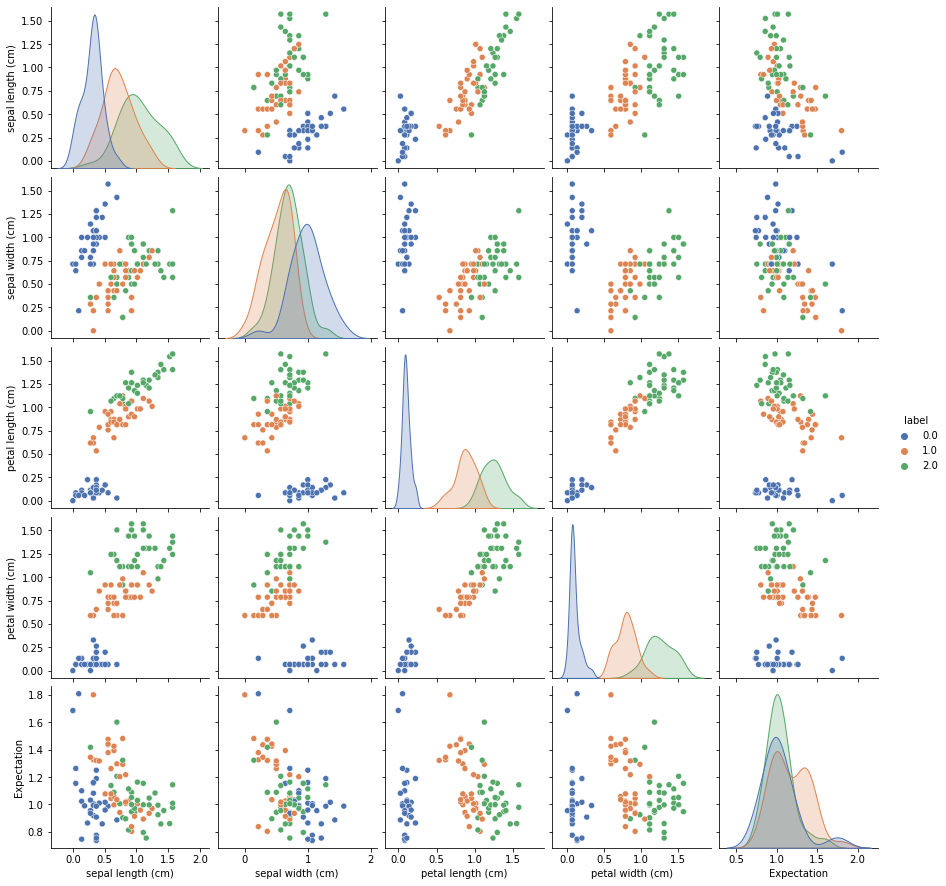

In [ ]:
sns.pairplot(train_df, hue="label", palette = 'deep')

Naive expectation values with random angle, very poor but thats expected.

In [ ]:
def cost_train(theta):
  #get predictions
  predictions = np.zeros(len(train_df))
  for i in range(len(train_df)):
    predictions[i] = get_expectation(train_df.iloc[i][0:4],U, theta)
  #Simple MSE example
  
  #predictions are currently expectation values
  L = ((predictions - y_train)**2).mean()

  return L

In [ ]:
train_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Expectation,label
0,0.646798,0.642598,0.869548,0.785398,1.394269,1.0
1,1.524596,0.713998,1.542746,1.308997,0.860470,2.0
2,0.600599,0.713998,0.953698,0.916298,1.043916,1.0
3,0.369599,1.070997,0.084150,0.065450,0.775660,0.0
4,1.570796,0.571199,1.570796,1.243547,0.979377,2.0


In [ ]:
cost_train(np.random.rand(7))

0.6676964884508356

In [ ]:
#find number of correct predictions
correct = 0
for i in range(len(y_train)):
  if y_train[i] == classi(train_df['Expectation'][i]):
    correct += 1

print('The initial calssification is',(correct/len(y_train)) * 100, '% accurate')


The initial calssification is 28.000000000000004 % accurate


### Optimise

In [ ]:
from scipy.optimize import minimize #BFGS works well/cobyla

In [ ]:
#%%time
#Use scipy minimised to find the vector theta that minimised the cost function.
theta_0 = np.random.rand(7)
result = minimize(cost_train, theta_0, method='cobyla')
theta = result.x

In [ ]:
theta, theta_0

(array([0.89709887, 2.22468799, 0.68978282, 0.66178326, 0.85107518,
        0.99751365, 0.6727646 ]),
 array([0.69064845, 0.13391954, 0.64968254, 0.57704431, 0.9255766 ,
        0.89540924, 0.52650419]))

In [ ]:
cost_train(theta)

0.3310802016216256

Reclasify

In [ ]:
def cost_test(theta):
  #get predictions
  predictions = np.zeros(len(test_df))
  for i in range(len(test_df)):
    predictions[i] = get_expectation(test_df.iloc[i][0:4],U,theta)
  #Simple MSE example
  L = ((predictions - y_test)**2).mean()
  return L

In [ ]:
cost_test(theta)

0.3520169533242737

In [ ]:
better_predictions = np.zeros(len(test_df))
expectations = np.zeros(len(test_df))
for i in range(len(test_df)):
  better_predictions[i] = classi(get_expectation(test_df.iloc[i][0:4],U, theta))
  expectations[i] = get_expectation(test_df.iloc[i][0:4],U, theta)

test_df.insert(4,'Expectation', expectations)
test_df.insert(5,'Prediction', better_predictions)

In [ ]:
test_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Expectation,Prediction,label
0,0.762958,0.428399,0.985076,0.719948,1.078716,1.0,1.0
1,0.583439,1.142397,0.186366,0.130900,0.912146,1.0,0.0
2,1.481037,0.285599,1.570796,1.439897,1.583203,2.0,2.0
3,0.718078,0.499799,0.931828,0.916298,1.040563,1.0,1.0
4,1.077117,0.428399,1.011699,0.850848,1.346650,2.0,1.0


In [ ]:
test_df.iloc[0][5]

1.0

In [ ]:
correct = 0
for i in range(len(test_df)):
  if test_df.iloc[i][5] == test_df.iloc[i][6]:
    correct += 1 

print('The final calssification is',(correct/len(test_df)) * 100, '% accurate')

The final calssification is 57.99999999999999 % accurate


### Prediction graphs

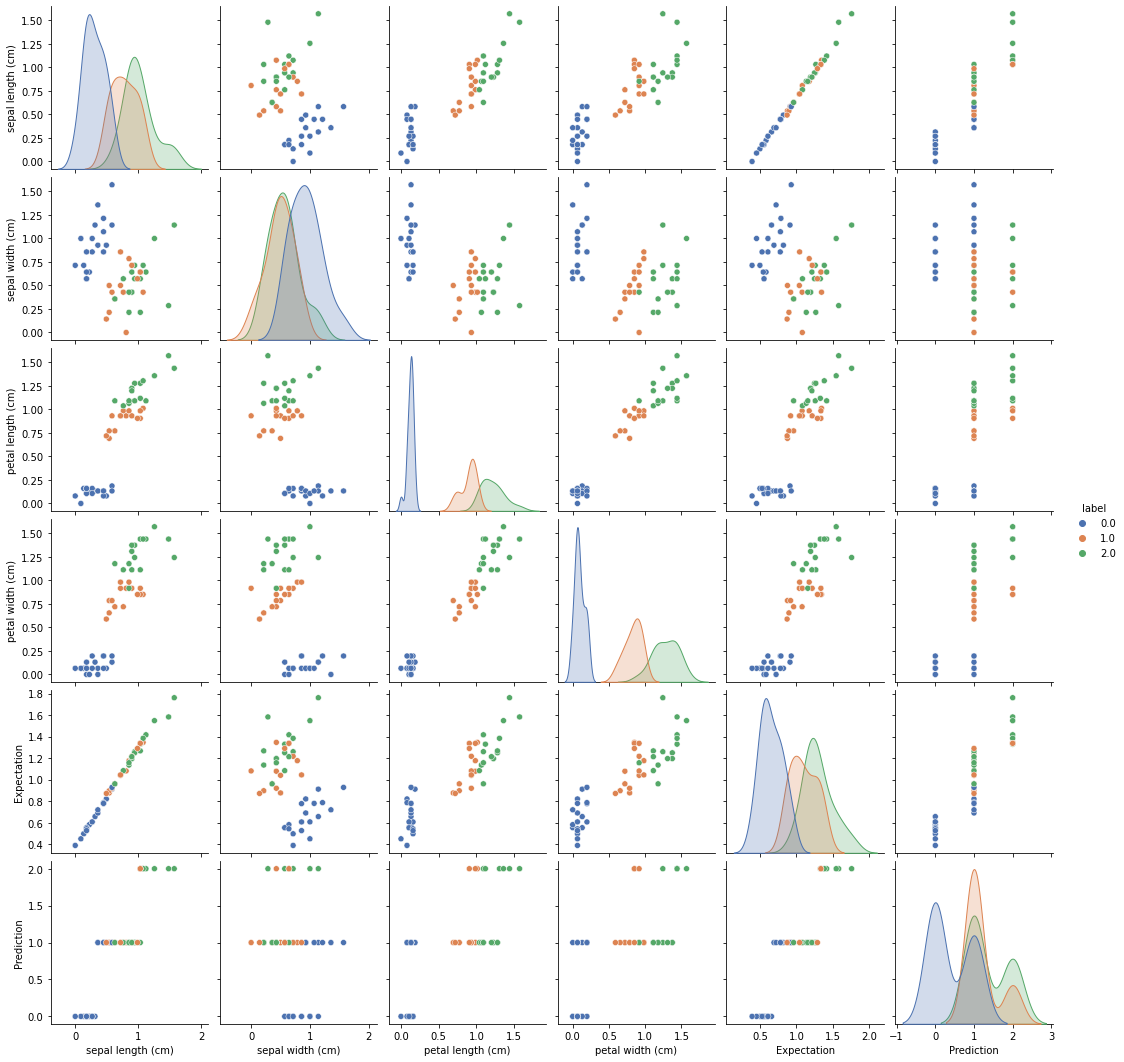

In [ ]:
sns.pairplot(test_df, hue="label", palette = 'deep')

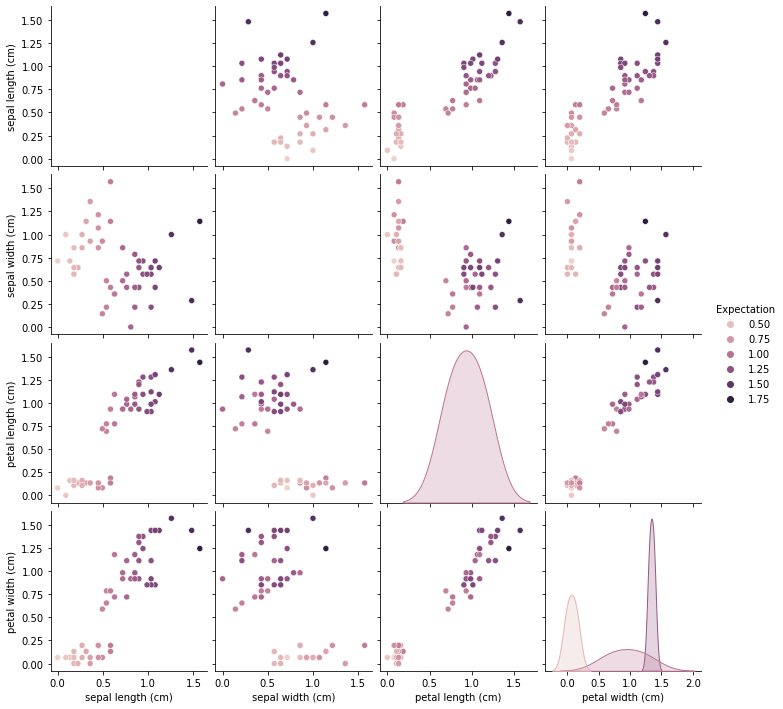

In [ ]:
sns.pairplot(test_df[test_df.columns[:5]], hue="Expectation")

# Binary Classification 

I will initially use the code from 

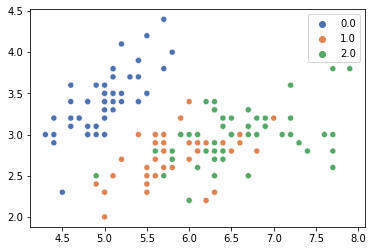

In [ ]:
sns.scatterplot(data=data, x=data[:,0], y=data[:,1], hue=data[:,4], palette="deep")

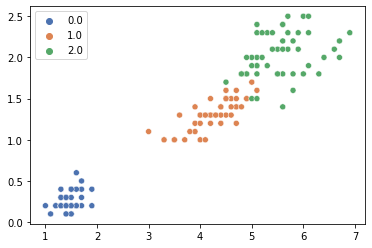

In [ ]:
sns.scatterplot(data=data, x=data[:,2], y=data[:,3], hue=data[:,4], palette="deep")

## Convert and visualise data

The embedding and computational circuits will be unchanged.

In [ ]:
#Copy data and alter labels for binar classification.
y_test_bi = y_test
y_train_bi = y_train

X_test_bi = X_test
X_train_bi = X_train

for i in range(len(y_test)):
  if y_test[i] == 2:
    y_test_bi[i] = 1

for i in range(len(y_train)):
  if y_train[i] == 2:
    y_train_bi[i] = 1


In [ ]:
normed_train_data_bi = half_pi_norm(X_train_bi)
normed_test_data_bi = half_pi_norm(X_test_bi)

[4.3 2.  1.1 0.1]
[3.4 2.2 5.6 2.4]
[4.4 2.2 1.  0.1]
[3.5 2.2 5.9 2.4]


In [ ]:
X_train_bi, X_test_bi, y_train_bi, y_test_bi = train_test_split(iris.data, iris.target, test_size=0.33, random_state=42)

for i in range(len(y_test_bi)):
  if y_test_bi[i] == 2:
    y_test_bi[i] = 1

for i in range(len(y_train_bi)):
  if y_train_bi[i] == 2:
    y_train_bi[i] = 1

train_data_bi = np.zeros((X_train_bi.shape[0], X_train_bi.shape[1] + 1))
train_data_bi[:,0:4] = X_train_bi
train_data_bi[:,4] = y_train_bi
train_df_bi = pd.DataFrame(data = train_data_bi, columns = features)

test_data_bi = np.zeros((X_test_bi.shape[0], X_test_bi.shape[1] + 1))
test_data_bi[:,0:4] = X_test_bi
test_data_bi[:,4] = y_test_bi
test_df_bi = pd.DataFrame(data = test_data_bi, columns = features)

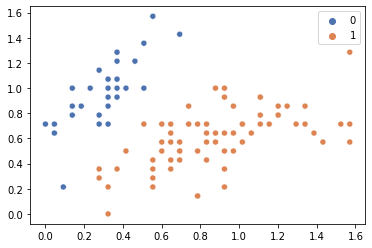

In [ ]:
sns.scatterplot(data=normed_train_data_bi, x=normed_train_data_bi[:,0], y=normed_train_data_bi[:,1], hue=y_train_bi, palette="deep")

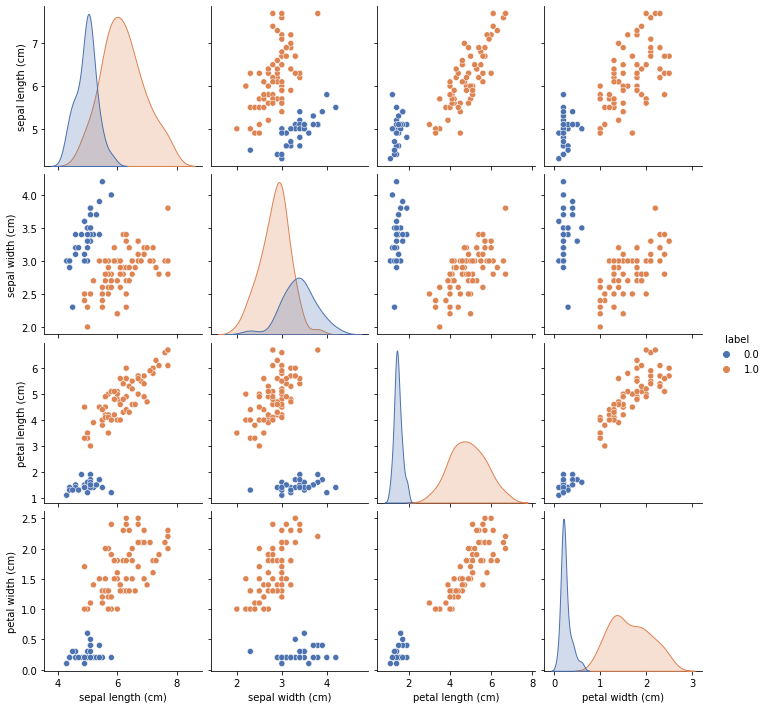

In [ ]:
sns.pairplot(train_df_bi, hue="label", palette = 'deep')